#Active Classification: pool-based sampling, uncertainty sampling and query by committee

In [ ]:
#!pip install modAL
!pip install modAL-python

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Pool-based sampling

## Overview

In this example, we apply an `ActiveLearner` onto the iris dataset using pool-based sampling. In this setting, we assume a small set of labeled data $\mathcal{L}$ and a large set of unlabeled data $\mathcal{U}$ such that $\left| \mathcal{L} \right| \ll \left| \mathcal{U} \right|$. In his review of the active learning literature, Settles covers a high-level overview of the general pool-based sampling algorithm:

> Queries are selectively drawn from the pool, which is usually assumed to be closed (i.e., static or non-changing), although this is not strictly necessary. Typically, instances are queried in a greedy fashion, according to an informativeness measure used to evaluate all instances in the pool (or, perhaps if $\mathcal{U}$ is very large, some subsample thereof).

Along with our pool-based sampling strategy, `modAL`'s modular design allows you to vary parameters surrounding the active learning process, including the core estimator and query strategy. In this example, we use `scikit-learn`'s [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as our estimator and default to `modAL`'s [uncertainty sampling](https://cosmic-cortex.github.io/modAL/Uncertainty-sampling) query strategy.

For further reading on pool-based sampling, we highly recommend the following resources:
- Burr Settles. [Active Learning Literature Survey](http://burrsettles.com/pub/settles.activelearning.pdf) [**Section 2.3: Pool-based Sampling**]. Computer Sciences Technical Report 1648, University of Wisconsin-Madison. 2009.

To enforce a reproducible result across runs, we set a random seed.

In [ ]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

## The dataset

Now we load the dataset. In this example, we are going to use the famous Iris dataset. For more information on the iris dataset, see:
  - [The dataset documentation on Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
  - [The scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

For visualization purposes, we apply PCA to the original dataset.

In [ ]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks like.

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our `iris` dataset into a training set $\mathcal{L}$ and $\mathcal{U}$. We first specify our training set $\mathcal{L}$ consisting of 3 random examples. The remaining examples go to our "unlabeled" pool $\mathcal{U}$.

In [ ]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

## Active learning with pool-based sampling

For the classification, we are going to use a simple k-nearest neighbors classifier. In this step, we are also going to initialize the ```ActiveLearner```.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

"To create an ActiveLearner object, you need to provide two things: a scikit-learn estimator object and a query strategy function (The latter one is optional, the default strategy is maximum uncertainty sampling.). Regarding the query strategies, you can find built-ins in modAL.uncertainty, but you can also implement your own. For instance, you can just simply do the following.

    from modAL.models import ActiveLearner
    from modAL.uncertainty import uncertainty_sampling
    from sklearn.ensemble import RandomForestClassifier

    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=uncertainty_sampling
    )

In modAL, currently there are three built-in query strategies: max uncertainty, max margin and max entropy(...)"

[https://github.com/modAL-python/modAL/blob/99d4947f69f0b2247f9916a6ef44463f7af06c55/docs/source/content/models/ActiveLearner.rst]

Let's see how our classifier performs on the initial training set!

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

In [ ]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

## Update our model by pool-based sampling our "unlabeled" dataset $\mathcal{U}$

As we can see, our model is unable to properly learn the underlying data distribution. All of its predictions are for the third class label, and as such it is only as competitive as defaulting its predictions to a single class – if only we had more data!

Below, we tune our classifier by allowing it to query 20 instances it hasn't seen before. Using uncertainty sampling, our classifier aims to reduce the amount of uncertainty in its predictions using a variety of measures — see the documentation for more on specific [classification uncertainty measures](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Uncertainty-sampling.html). With each requested query, we remove that record from our pool $\mathcal{U}$ and record our model's accuracy on the raw dataset.

In [ ]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  print("X type: ", type(X))
  print("X shape: ", X.shape)
  print("y shape: ", y.shape)
  learner.teach(X=X, y=y)

  learner_X_training = learner.X_training
  print("learner_X_training type: ", type(learner_X_training))
  print("learner_X_training shape: ", learner_X_training.shape)
  print("learner_X_training shape: ", learner_X_training.shape)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  print("X_pool type: ", type(X_pool))
  print("X_pool shape: ", X_pool.shape)
  print("y_pool shape: ", y_pool.shape)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  print("X_raw type: ", type(X_raw))
  print("X_raw shape: ", X_raw.shape)
  print("y_raw shape: ", y_raw.shape)


  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#Szwabe: Proper evaluation: on the pool excluding the teaching pool (Please comment on the differences)

In [ ]:
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

In [ ]:
import copy

In [ ]:
X_pool = copy.deepcopy(X_raw)
y_pool = copy.deepcopy(y_raw)

In [ ]:
#unqueried_score = learner.score(X_raw, y_raw)
unqueried_score = learner.score(X_pool, y_pool)

In [ ]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  print("X type: ", type(X))
  print("X shape: ", X.shape)
  print("y shape: ", y.shape)
  learner.teach(X=X, y=y)

  learner_X_training = learner.X_training
  print("learner_X_training type: ", type(learner_X_training))
  print("learner_X_training shape: ", learner_X_training.shape)
  print("learner_X_training shape: ", learner_X_training.shape)


  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  print("X_pool type: ", type(X_pool))
  print("X_pool shape: ", X_pool.shape)
  print("y_pool shape: ", y_pool.shape)

  # (previous approach) model_accuracy = learner.score(X_raw, y_raw)
  # 1. [#154974] Previous approach included labeling the examples that it already learned,
  # therefore the incremental plot (effectively, the only element incfluenced by that),
  # might be a bit misleading.
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_pool, y_pool)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)


## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#Szwabe: Even more proper evaluation: on the pool excluding the teaching pool with prior raw data shuffling (Please comment on the differences)

[#154974] Here, we shuffle the elements before teaching the learner and increase the number of queries. And the result is equal to 1.000 accuracy. Seems to be almost ideal with the exception of couple of misclassified cases. But be it as it might, 50 number of queries (30 queries more) plays a big part of classification improvement. However, after setting the number of queries to 20, the accuracy is higher than compared to the first two, and equals 0.984.

In [ ]:
np.random.seed(RANDOM_STATE_SEED)
np.random.seed()

In [ ]:
not_yet_shuffling_indices = np.arange(y_raw.shape[0])
not_yet_shuffling_indices

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)

In [ ]:
shuffling_indices = not_yet_shuffling_indices
shuffling_indices

In [ ]:
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

In [ ]:
# Isolate our examples for our labeled dataset.
#n_labeled_examples = X_raw.shape[0]

#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

In [ ]:
N_QUERIES = 20
# N_QUERIES = 50
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  print("X type: ", type(X))
  print("X shape: ", X.shape)
  print("y shape: ", y.shape)
  learner.teach(X=X, y=y)

  learner_X_training = learner.X_training
  print("learner_X_training type: ", type(learner_X_training))
  print("learner_X_training shape: ", learner_X_training.shape)
  print("learner_X_training shape: ", learner_X_training.shape)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  print("X_pool type: ", type(X_pool))
  print("X_pool shape: ", X_pool.shape)
  print("y_pool shape: ", y_pool.shape)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_pool, y_pool)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

Uncertainty sampling
==================

When you present unlabelled examples to an active learner, it finds you the most *useful* example and presents it for you to be labelled. This is done by first calculating the *usefulness* of prediction (whatever it means) for each example and select an instance based on the usefulness. The thing is, there are several ways to measure this. They are based upon the classification uncertainty, hence they are called *uncertainty measures*. In modAL, currently you can select from three built-in measures: *classification uncertainty*, *classification margin* and *classification entropy*. In this quick tutorial, we are going to review them. For more details, see Section 2.3 of the awesome book [Active learning by Burr Settles](http://active-learning.net/)!

In [ ]:
import numpy as np

Classification uncertainty
-------------------------------------

The simplest measure is the uncertainty of classification defined by

$$U(x)=1-P(\hat{x}|x)$$

where $x$ is the instance to be predicted and $\hat{x}$ is the most likely prediction.

For example, if you have classes ``[0, 1, 2]`` and classification probabilities ``[0.1, 0.2, 0.7]``, the most likely class according to the classifier is ``2`` with uncertainty 0.3. If you have three instances with class probabilities

In [ ]:
proba = np.array([[0.1 , 0.85, 0.05],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding uncertainties are:

In [ ]:
1 - proba.max(axis=1)

In the above example, the most uncertain sample is the second one. When
querying for labels based on this measure, the strategy selects the
sample with the highest uncertainty.

For this ternary classification problem, given the first two
probabilities, the classification uncertainty looks like the following.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product
n_res = 100
p1, p2 = np.meshgrid(np.linspace(0, 1, n_res), np.linspace(0, 1, n_res))
p3 = np.maximum(1 - p1 - p2, 0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
plt.style.available

In [ ]:
uncertainty = 1 - np.maximum.reduce([p1, p2, p3])

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, uncertainty*((p1+p2) < 1), 100)
    plt.title('Classification uncertainty for ternary classification')

## Szwabe: What about a 2-class case? (Please comment on the differences)

[#154974] The 3-D case is pyramid-like, therefore the slices (2-D cases) follow the obvious pattern. If you go on the edge, the values of the scores create a triange. Going from center of one edge to another on the same side of the pyramid causes no difference in the score values.

In [ ]:
p1.shape

In [ ]:
for p1_slice_idx in range(p1.shape[0]):
  p1_slice = p1[p1_slice_idx, :]


In [ ]:
plt.plot(p1_slice)

In [ ]:
p2_slice = 1 - p1_slice

In [ ]:
uncertainty_slice = 1 - np.maximum.reduce([p1_slice, p2_slice])
plt.plot(p1_slice, uncertainty_slice)
plt.title('Binary classification uncertainty')
plt.xlabel('Class probability')
plt.ylabel('Classification uncertainty')
plt.show()

In [ ]:
p1[-1, :] == p1_slice

In [ ]:
p1[-1, :] == p1[-2, :]

In [ ]:
uncertainty.shape

In [ ]:
plt.plot(uncertainty[:,50])
plt.show()

In [ ]:
plt.plot(uncertainty[:,10])
plt.show()

In [ ]:
plt.plot(uncertainty[:,0])
plt.show()

In [ ]:
plt.plot(uncertainty[:,90])
plt.show()

Classification margin
-------------------------------

Classification margin is the difference in probability of the first and second most likely prediction, that is, it is defined by

$$M(x)=P(\hat{x_1}|x)-P(\hat{x_2}|x)$$

where $\hat{x_1}$ and $\hat{x_2}$ are the first and second most likely classes. Using the same example we used for classification uncertainty, if the class probabilities are

In [ ]:
proba = np.array([[0.1 , 0.85, 0.05],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding margins are:

In [ ]:
part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

In [ ]:
margin

When querying for labels, the strategy selects the sample with the *smallest* margin, since the smaller the decision margin is, the more unsure the decision. In this case, it would be the third sample. For this ternary classification problem, the classifier margin plotted against the first two probabilities are the following.

In [ ]:
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T

part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

margin = margin.reshape(p1.shape)

In [ ]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, (1-margin)*((p1+p2) < 1), 100)
    plt.title('Classification margin for ternary classification')

## Szwabe: What about a 2-class case? (Please comment on the differences)

[#154974] This case is more complex than other, it has more moving parts (one more probability to consider). While on the edge of the "tower" it looks pretty similar (except that in the center it gets the highest possible value), the other slices are notably different, so that even on the same slice you can observe zig-zags.

In [ ]:
plt.plot((1-margin)[:,0])
plt.show()

In [ ]:
plt.plot((1-margin)[:,10])
plt.show()

In [ ]:
plt.plot((1-margin)[:,90])
plt.show()

Classification entropy
--------------------------------

The third built-in uncertainty measure is the classification entropy, which is defined by

$$H(x)=-\sum_{k}p_k\log(p_k)$$

where $p_k$ is the probability of the sample belonging to the $k$-th class. Heuristically, the entropy is proportional to the average number of guesses one has to make to find the true class. In our usual example

In [ ]:
proba = np.array([[0.1 , 0.85, 0.05],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding entropies are

In [ ]:
from scipy.stats import entropy

entropy(proba.T)

The closer the distribution to uniform, the larger the entropy. Again, if we plot the entropy against the first two probabilities of a ternary classification problem, we obtain the following.

In [ ]:
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T
entr = entropy(proba.T).reshape(p1.shape)

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, entr*((p1+p2) < 1), 100)
    plt.title('Entropy for ternary classification')

In [ ]:
plt.plot(entr[:,0])
plt.title('Binary entropy')
plt.xlabel('Class probability')
plt.ylabel('Classification uncertainty')
plt.show()

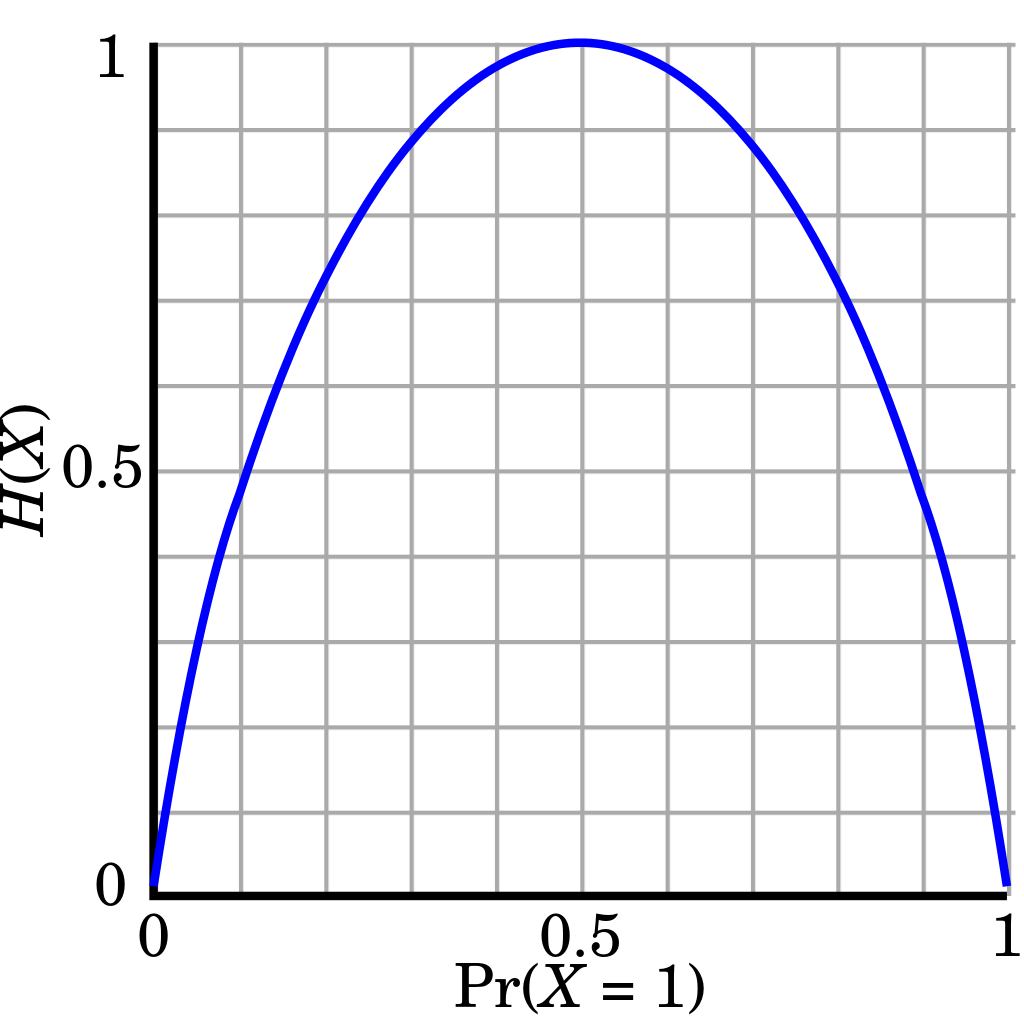

Entropy of a Bernoulli trial as a function of binary outcome probability, called the binary entropy function.

[https://en.wikipedia.org/wiki/Binary_entropy_function]

In [ ]:
plt.plot(entr[:,50])
plt.show()

## Szwabe: What about a 2-class case? (Please comment on the differences)

[#154974] Looks like a smooth mountain, and 2-D slices are corresponding. This is quite different from the 2 previous approaches, the gradient of the score function changes constantly.

Query by committee
=================

*Query by committee* is another popular active learning strategy, which alleviates many disadvantages of uncertainty sampling. For instance, uncertainty sampling tends to be biased towards the actual learner and it may miss important examples which are not in the sight of the estimator. This is fixed by keeping several hypotheses at the same time, selecting queries where disagreement occurs between them. In this example, we shall see how this works in the simplest case, using the iris dataset.

The executable script for this example is [available here](https://github.com/cosmic-cortex/modAL/blob/master/examples/query_by_committee.py)!

To enforce a reproducible result across runs, we set a random seed.

In [ ]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

The dataset
-----------------

We are going to use the iris dataset for this example. For more information on the iris dataset, see [its wikipedia page](https://en.wikipedia.org/wiki/Iris_flower_data_set). For its scikit-learn interface, see [the scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html).

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# loading the iris dataset
iris = load_iris()

# visualizing the classes
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=iris['target'], cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()


In [ ]:
print(iris["DESCR"])

Initializing the Committee
--------------------------

In this example, we are going to use the ``Committee`` class from ``modAL.models``. Its interface is almost exactly identical to the
``ActiveLearner``. Upon initialization, ``Committee`` requires a list of active learners. First, we generate the pool of unlabeled data.

In [ ]:
from copy import deepcopy

# generate the pool
X_pool = deepcopy(iris['data'])
y_pool = deepcopy(iris['target'])

Now we are ready to initialize the ```Committee```. For this, we need a list of ```ActiveLearner``` objects, which we will define now.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner, Committee

# initializing Committee members
n_members = 2
learner_list = list()

for member_idx in range(n_members):
    # initial training data
    n_initial = 2
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

As you can see, the various hypotheses (which are taking the form of ActiveLearners) can be quite different.

In [ ]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

Prediction is done by averaging the class probabilities for each learner and chosing the most likely class.

In [ ]:
unqueried_score = committee.score(iris['data'], iris['target'])

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee initial predictions, accuracy = %1.3f' % unqueried_score)
    plt.show()

Active learning
----------------------

The active learning loop is the same as for the ``ActiveLearner``.

In [ ]:
performance_history = [unqueried_score]

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(iris['data'], iris['target']))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

After a few queries, the hypotheses straighten out their disagreements and they reach consensus. Prediction accuracy is greatly improved in this case.

In [ ]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries))
    plt.show()

In [ ]:
# visualizing the Committee's predictions
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries, committee.score(iris['data'], iris['target'])))
    plt.show()

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Szwabe: What about a 2-class case? (Please comment on the differences)

[#154974] overall, while being quite distinct between each other, they have the same in common (actually in either 3D or 2D). They evaluate the highest when the probabilities of 3 (or 2) classes, are identical.

#Comparison of query strategies

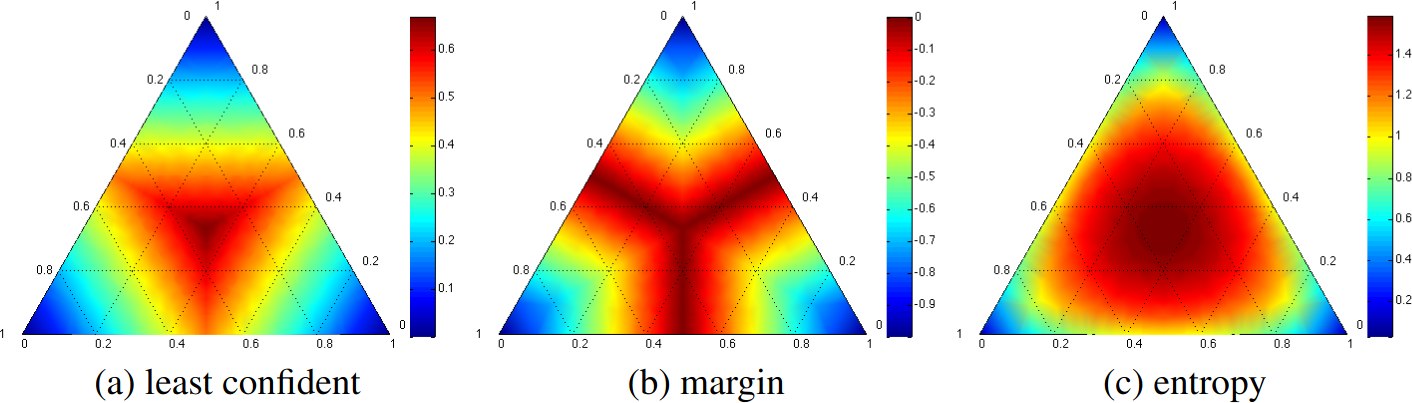

Heatmaps illustrating the query behavior of the common query strategies (aka uncertainty measures) in a three-label classification problem.
Corners indicate cases/samples where one label has very high probability, with the opposite edge showing the probability range for the other two classes when that label has very low probability.
The most informative query region for each strategy is shown in dark red, radiating from the centers. [Settles, Burr. "Active learning literature survey." (2009), https://minds.wisconsin.edu/bitstream/handle/1793/60660/TR1648.pdf]

In [ ]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

In [ ]:
#query_strategy=uncertainty_sampling

In [ ]:
np.random.seed(RANDOM_STATE_SEED)
np.random.seed()

In [ ]:
not_yet_shuffling_indices = np.arange(y_raw.shape[0])
not_yet_shuffling_indices

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)

In [ ]:
shuffling_indices = not_yet_shuffling_indices
shuffling_indices

In [ ]:
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

In [ ]:
# Isolate our examples for our labeled dataset.
#n_labeled_examples = X_raw.shape[0]

#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

In [ ]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

In [ ]:
query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling]
query_strategy_labels = ["uncertainty sampling", "margin sampling", "entropy sampling"]

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

performance_histories = []

for query_strategy in query_strategies:

  #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
  training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

  X_train = X_raw[training_indices]
  y_train = y_raw[training_indices]

  # Isolate the non-training examples we'll be querying.
  X_pool = np.delete(X_raw, training_indices, axis=0)
  y_pool = np.delete(y_raw, training_indices, axis=0)

  knn = KNeighborsClassifier(n_neighbors=3)
  learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

  N_QUERIES = 20
  #N_QUERIES = 50
  unqueried_score = learner.score(X_pool, y_pool)
  performance_history = [unqueried_score]

  # Allow our model to query our unlabeled dataset for the most
  # informative points according to our query strategy (uncertainty sampling).
  for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    print("X type: ", type(X))
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    learner.teach(X=X, y=y)

    learner_X_training = learner.X_training
    print("learner_X_training type: ", type(learner_X_training))
    print("learner_X_training shape: ", learner_X_training.shape)
    print("learner_X_training shape: ", learner_X_training.shape)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
    print("X_pool type: ", type(X_pool))
    print("X_pool shape: ", X_pool.shape)
    print("y_pool shape: ", y_pool.shape)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_pool, y_pool)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
  performance_histories.append(performance_history)

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

for query_strategy_idx, query_strategy in enumerate(query_strategies):
  performance_history = performance_histories[query_strategy_idx]
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  ax.plot(performance_history, label=query_strategy_label)
  ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#Szwabe: More reliable comparison of query strategies  (Please comment on the differences)

In [ ]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

In [ ]:
#query_strategy=uncertainty_sampling

In [ ]:
#np.random.seed(RANDOM_STATE_SEED)
np.random.seed()

In [ ]:
not_yet_shuffling_indices = np.arange(y_raw.shape[0])
not_yet_shuffling_indices

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)

In [ ]:
shuffling_indices = not_yet_shuffling_indices
shuffling_indices

In [ ]:
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

In [ ]:
# Isolate our examples for our labeled dataset.
#n_labeled_examples = X_raw.shape[0]

#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

In [ ]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

In [ ]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

In [ ]:
from numpy.random.mtrand import random_sample
#query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling]
#query_strategy_labels = ["uncertainty sampling", "margin sampling", "entropy sampling"]
query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling, random_sampling]
query_strategy_labels = ["uncertainty sampling", "margin sampling", "entropy sampling", "random sampling"]

In [ ]:
#performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[]}


In [ ]:
performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[], "random sampling":[]}
number_of_tests = 44

for test_number in range(number_of_tests):

  np.random.shuffle(not_yet_shuffling_indices)
  X_raw = X_raw[shuffling_indices]
  y_raw = y_raw[shuffling_indices]

  #performance_histories = []

  for query_strategy_idx, query_strategy in enumerate(query_strategies):

    query_strategy_label = query_strategy_labels[query_strategy_idx]

    #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    knn = KNeighborsClassifier(n_neighbors=3)
    learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

    N_QUERIES = 20
    #N_QUERIES = 50
    unqueried_score = learner.score(X_pool, y_pool)
    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      print("X type: ", type(X))
      print("X shape: ", X.shape)
      print("y shape: ", y.shape)
      learner.teach(X=X, y=y)

      learner_X_training = learner.X_training
      print("learner_X_training type: ", type(learner_X_training))
      print("learner_X_training shape: ", learner_X_training.shape)
      print("learner_X_training shape: ", learner_X_training.shape)

      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
      print("X_pool type: ", type(X_pool))
      print("X_pool shape: ", X_pool.shape)
      print("y_pool shape: ", y_pool.shape)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_pool, y_pool)
      print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

      #Szwabe: Could we use (and evaluate) another predictive model for the actual ('on-production') predictions in parallel to the active learner? What properties such a system would have if we did use an additional main predictor and the query strategy was random sampling?
      # [#154974] Yes, in fact this is a common practice in corporate environment. This would enable experiments on active learning without affecting client experience. Sort of like a git flow style with dev and main branches.
      # Random sampling is robust and unbiased, but prone to slow adoption since the strategy is not optimized fo quick learning.

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    performance_histories[query_strategy_label].append(performance_history)




In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
temp_color_letters = ["b", "y", "g", "r"]


for query_strategy_idx, query_strategy in enumerate(query_strategies):
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  performance_history = performance_histories[query_strategy_label]
  #ax.plot(performance_history, label=query_strategy_label)
  #ax.scatter(range(len(performance_history)), performance_history, s=13)
  temp_mean = np.mean(np.array(performance_history), axis=0)
  temp_std = np.std(np.array(performance_history), axis=0)
  temp_color_letter = temp_color_letters[query_strategy_idx]
  x = np.arange(len(temp_mean))
  plt.plot(x, temp_mean, temp_color_letter+"-", label=query_strategy_label)
  plt.fill_between(x, temp_mean - temp_std, temp_mean + temp_std, color=temp_color_letter, alpha=0.2)


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

#Szwabe: Set an appropriate number of test repetitions in order to compare practical value of the four sampling strategies in the most reliable way that is still feasible considering the amount of available time (of the classwork). Compare and comment on the practical value of the strategies.

In [ ]:
performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[], "random sampling":[]}
number_of_tests = 667

for test_number in range(number_of_tests):

  np.random.shuffle(not_yet_shuffling_indices)
  X_raw = X_raw[shuffling_indices]
  y_raw = y_raw[shuffling_indices]

  #performance_histories = []

  for query_strategy_idx, query_strategy in enumerate(query_strategies):

    query_strategy_label = query_strategy_labels[query_strategy_idx]

    #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    knn = KNeighborsClassifier(n_neighbors=3)
    learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

    N_QUERIES = 20
    #N_QUERIES = 50
    unqueried_score = learner.score(X_pool, y_pool)
    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      print("X type: ", type(X))
      print("X shape: ", X.shape)
      print("y shape: ", y.shape)
      learner.teach(X=X, y=y)

      learner_X_training = learner.X_training
      print("learner_X_training type: ", type(learner_X_training))
      print("learner_X_training shape: ", learner_X_training.shape)
      print("learner_X_training shape: ", learner_X_training.shape)

      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
      print("X_pool type: ", type(X_pool))
      print("X_pool shape: ", X_pool.shape)
      print("y_pool shape: ", y_pool.shape)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_pool, y_pool)
      print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    performance_histories[query_strategy_label].append(performance_history)

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
temp_color_letters = ["b", "y", "g", "r"]


for query_strategy_idx, query_strategy in enumerate(query_strategies):
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  performance_history = performance_histories[query_strategy_label]
  #ax.plot(performance_history, label=query_strategy_label)
  #ax.scatter(range(len(performance_history)), performance_history, s=13)
  temp_mean = np.mean(np.array(performance_history), axis=0)
  temp_std = np.std(np.array(performance_history), axis=0)
  temp_color_letter = temp_color_letters[query_strategy_idx]
  x = np.arange(len(temp_mean))
  plt.plot(x, temp_mean, temp_color_letter+"-", label=query_strategy_label)
  plt.fill_between(x, temp_mean - temp_std, temp_mean + temp_std, color=temp_color_letter, alpha=0.2)


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

In [ ]:
!pip freeze